In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pixelMaxValue = 255
'''
Could alternatively use:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_images = scaler.fit_transform(df)
'''
imageHeight = 28
imageWidth = 28

In [2]:
df = pd.read_csv('train.csv')
display(df.head())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Drop 'label' column and normalize the data
X = (df.drop('label', axis=1) / pixelMaxValue).to_numpy()

# Reshape the data
num_samples = df.shape[0]
X = X.reshape(num_samples, imageHeight, imageWidth, 1)

# One-hot encode the labels
y = pd.get_dummies(df['label'])

# Print shape of X and its first two dimensions
# print(len(X))
# print(len(X[0]))
# print(len(X[0][0]))
# print(y.columns)

In [4]:
model = Sequential()

model.add(Conv2D(filters=32, 
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(imageHeight, imageWidth, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [6]:
# these items are an attempt to improve the accuracy
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
datagen.fit(X_train)
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(filepath='best_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=True)


In [7]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=40),
        #X_train, y_train, 
        #batch_size=40, 
        epochs=25, 
        verbose=1, 
        validation_data=(X_test, y_test), 
        steps_per_epoch=len(X_train) // 40,
        callbacks=[early_stopping, model_checkpoint],
        max_queue_size=20, 
        # workers=16, 
        use_multiprocessing=False)
'''
Best weights will be saved:
weights_path = 'best_model.h5'
moodel.load_weights(weights_path)
'''

Epoch 1/25
787/787 [==============================] - 11s 14ms/step - loss: 0.6663 - accuracy: 0.7799 - val_loss: 0.1569 - val_accuracy: 0.9513
Epoch 2/25
787/787 [==============================] - 10s 13ms/step - loss: 0.2939 - accuracy: 0.9080 - val_loss: 0.1186 - val_accuracy: 0.9641
Epoch 3/25
787/787 [==============================] - 10s 13ms/step - loss: 0.2285 - accuracy: 0.9272 - val_loss: 0.0798 - val_accuracy: 0.9749
Epoch 4/25
787/787 [==============================] - 10s 13ms/step - loss: 0.1993 - accuracy: 0.9387 - val_loss: 0.0739 - val_accuracy: 0.9781
Epoch 5/25
787/787 [==============================] - 10s 13ms/step - loss: 0.1757 - accuracy: 0.9456 - val_loss: 0.0747 - val_accuracy: 0.9760
Epoch 6/25
787/787 [==============================] - 10s 13ms/step - loss: 0.1636 - accuracy: 0.9490 - val_loss: 0.0685 - val_accuracy: 0.9785
Epoch 7/25
787/787 [==============================] - 10s 13ms/step - loss: 0.1497 - accuracy: 0.9538 - val_loss: 0.0688 - val_accuracy:

"\nBest weights will be saved:\nweights_path = 'best_model.h5'\nmoodel.load_weights(weights_path)\n"

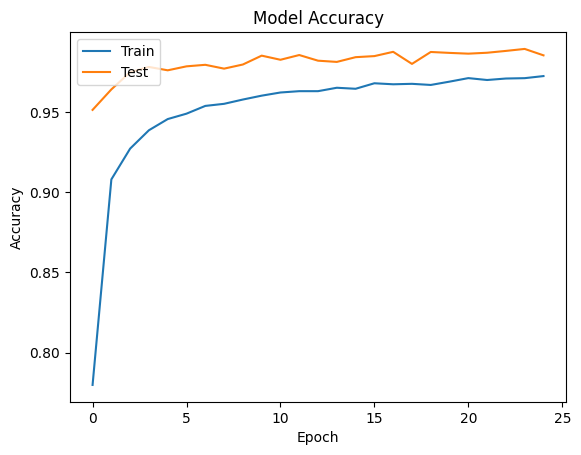

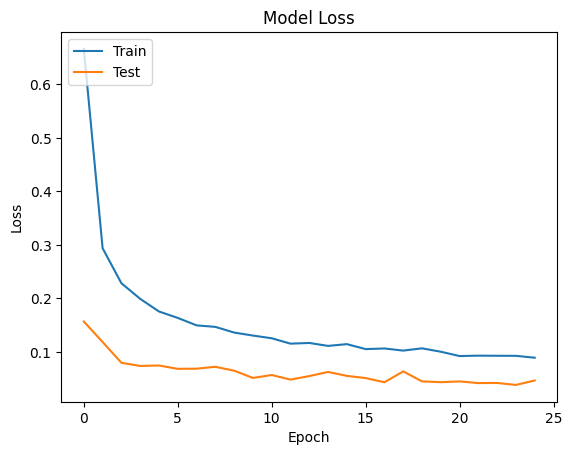

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
df = pd.read_csv('test.csv')
# Drop 'label' column and normalize the data
X = (df / pixelMaxValue).to_numpy()

# Reshape the data
num_samples = df.shape[0]
X = X.reshape(num_samples, imageHeight, imageWidth)

y = model.predict(X)
y = np.argmax(y, axis=1)
image_ids = np.arange(1, len(y) + 1)
output = pd.DataFrame({"ImageId": image_ids, "Label": y})
output.head()
output.to_csv('submission.csv', index=False)

875/875 [==============================] - 3s 3ms/step
